In [6]:
# code from: https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

import pandas as pd
from sklearn.model_selection import train_test_split

raw_data_path = '/home/paul/Desktop/Paul/PyTorch-Hackathon-2020/cheng-news/news.csv'
destination_folder = '/home/paul/Desktop/Paul/PyTorch-Hackathon-2020/cheng-news'

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [8]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [20]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):


        
        text_emb = self.embedding(text)

        output, h = self.lstm(text_emb)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)

        packed_output, _ = self.lstm(packed_input)

        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]

        out_reverse = output[:, 0, self.dimension:]

        out_reduced = torch.cat((out_forward, out_reverse), 1)

        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)

        text_fea = torch.squeeze(text_fea, 1)

        text_out = torch.sigmoid(text_fea)

        return text_out

In [16]:
# preprocess kaggle dataset
kaggle_data_path = '/home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news/Combined.csv'
kaggle_destination_folder = '/home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news/'

# read in csv file
df_kaggle_raw = pd.read_csv(kaggle_data_path)

# prepare columns
df_kaggle_raw['label'] = (df_kaggle_raw['authenticity'] == 'Fake').astype(int)
df_kaggle_raw['titletext'] = df_kaggle_raw['title'] + ". " + df_kaggle_raw['text']
df_kaggle_raw = df_kaggle_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_kaggle_raw.drop( df_kaggle_raw[df_kaggle_raw.text.str.len() < 5].index, inplace=True)

# Trim texts to first n words
df_kaggle_raw['text'] = df_kaggle_raw['text'].apply(trim_string)
df_kaggle_raw['titletext'] = df_kaggle_raw['titletext'].apply(trim_string)

# Split into real and fake
df_kaggle_real = df_kaggle_raw[df_kaggle_raw['label'] == 0]
df_kaggle_fake = df_kaggle_raw[df_kaggle_raw['label'] == 1]

# Train-test split
df_kaggle_real_full_train, df_kaggle_real_test = train_test_split(df_kaggle_real, train_size = train_test_ratio, random_state = 1)
df_kaggle_fake_full_train, df_kaggle_fake_test = train_test_split(df_kaggle_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_kaggle_real_train, df_kaggle_real_valid = train_test_split(df_kaggle_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_kaggle_fake_train, df_kaggle_fake_valid = train_test_split(df_kaggle_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_kaggle_train = pd.concat([df_kaggle_real_train, df_kaggle_fake_train], ignore_index=True, sort=False)
df_kaggle_valid = pd.concat([df_kaggle_real_valid, df_kaggle_fake_valid], ignore_index=True, sort=False)
df_kaggle_test = pd.concat([df_kaggle_real_test, df_kaggle_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(kaggle_destination_folder + '/train.csv', index=False)
df_valid.to_csv(kaggle_destination_folder + '/valid.csv', index=False)
df_test.to_csv(kaggle_destination_folder + '/test.csv', index=False)

In [51]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

kaggle_train, kaggle_valid, kaggle_test = TabularDataset.splits(path='/home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news/', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)


# Iterators

kaggle_train_iter = BucketIterator(kaggle_train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=None, sort=True, sort_within_batch=True)
kaggle_valid_iter = BucketIterator(kaggle_valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=None, sort=True, sort_within_batch=True)
kaggle_test_iter = BucketIterator(kaggle_test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=None, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(kaggle_train, min_freq=3)

In [52]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=None)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=None)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [53]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = kaggle_train_iter,
          valid_loader = kaggle_valid_iter,
          num_epochs = 5,
          eval_every = len(kaggle_train_iter) // 2,
          file_path = kaggle_destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
#             labels = labels.to(device)
#             titletext = titletext.to(device)
#             titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
#                       labels = labels.to(device)
#                       titletext = titletext.to(device)
#                       titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


# model = LSTM().to(device)
model = LSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [8/160], Train Loss: 0.6990, Valid Loss: 0.6674
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//model.pt
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//metrics.pt
Epoch [1/10], Step [16/160], Train Loss: 0.6877, Valid Loss: 0.6515
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//model.pt
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//metrics.pt
Epoch [2/10], Step [24/160], Train Loss: 0.5777, Valid Loss: 0.6372
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//model.pt
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//metrics.pt
Epoch [2/10], Step [32/160], Train Loss: 0.5947, Valid Loss: 0.6212
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//model.pt
Model saved to ==> /home/paul/Desktop/Paul/PyTorch-Hackath

Model loaded from <== /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//metrics.pt


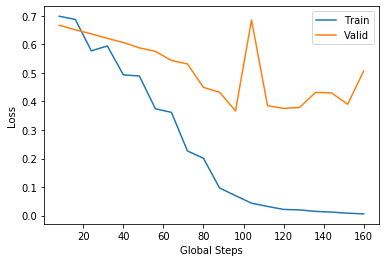

In [54]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(kaggle_destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /home/paul/Desktop/Paul/PyTorch-Hackathon-2020/fake_and_real_news//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8050    0.7390    0.7706      2816
           0     0.7618    0.8234    0.7914      2854

    accuracy                         0.7815      5670
   macro avg     0.7834    0.7812    0.7810      5670
weighted avg     0.7832    0.7815    0.7811      5670



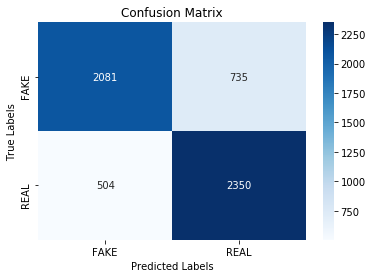

In [55]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
#             labels = labels.to(device)
#             titletext = titletext.to(device)
#             titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
# best_model = LSTM().to(device)
kaggle_best_model = LSTM()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(kaggle_destination_folder + '/model.pt', kaggle_best_model, optimizer)
evaluate(kaggle_best_model, test_iter)

In [56]:
item = next(iter(kaggle_train_iter))

In [57]:
item


[torchtext.data.batch.Batch of size 32]
	[.label]:[torch.FloatTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x20]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x58]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x69]', '[torch.LongTensor of size 32]')

In [58]:
kaggle_best_model(item.titletext[0], item.titletext[1])

tensor([0.0236, 0.9853, 0.9945, 0.9651, 0.9596, 0.9727, 0.8820, 0.9872, 0.0532,
        0.9931, 0.9542, 0.0087, 0.9443, 0.9974, 0.0305, 0.9873, 0.0082, 0.0035,
        0.0058, 0.0057, 0.0125, 0.0035, 0.0066, 0.0014, 0.0015, 0.0028, 0.0012,
        0.0024, 0.0017, 0.0242, 0.9653, 0.8190], grad_fn=<SigmoidBackward>)

In [59]:
# print trainset text, label; print model's prediction

def print_prediction():
    item = next(iter(kaggle_train_iter))
    print(item.titletext, 'titletext')
    print(item.label, 'label')
    
    item_titletext = item.titletext[0]
    item_titletext_len = item.titletext[1]
    
    pred = kaggle_best_model(item_titletext, item_titletext_len)
    pred_detached = pred.detach().numpy()
    print(pred)
    
    # plot labels and predictions
    plt.figure()
    plt.plot(item.label)
    plt.plot(pred_detached)



(tensor([[2470,  175,  452,  ..., 3195,    4,    1],
        [1430,    3,    0,  ...,  462,    2, 2019],
        [5073,  748, 3290,  ...,    1,    1,    1],
        ...,
        [1554,    7,    0,  ...,    1,    1,    1],
        [ 272, 3831,   15,  ...,    1,    1,    1],
        [   2, 1095, 1677,  ...,    1,    1,    1]]), tensor([68, 69, 64, 60, 63, 58, 62, 62, 48, 51, 39, 39, 48, 41, 33, 40, 34, 32,
        31, 32, 26, 30, 29, 30, 30, 30, 31, 29, 29, 26, 19, 13])) titletext
tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]) label
tensor([0.0236, 0.9853, 0.9945, 0.9651, 0.9596, 0.9727, 0.8820, 0.9872, 0.0532,
        0.9931, 0.9542, 0.0087, 0.9443, 0.9974, 0.0305, 0.9873, 0.0082, 0.0035,
        0.0058, 0.0057, 0.0125, 0.0035, 0.0066, 0.0014, 0.0015, 0.0028, 0.0012,
        0.0024, 0.0017, 0.0242, 0.9653, 0.8190], grad_fn=<SigmoidBackward>)


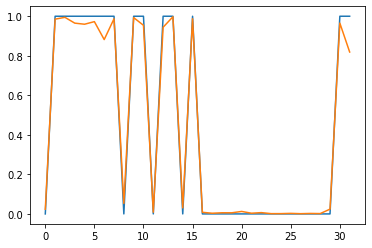

In [60]:
print_prediction()